# Exercício Programa 2 - MAC0209 - Modelagem e Simulação 
## Grupo: Eduardo Nascimento, Gabriel Massukado, Larissa Goto, Nathalia Borin, Matheus Lima

## Introdução

Para o segundo projeto de MAC0209, tivemos que modelar e simular 3 situações físicas: um movimento bidimensional, um lançamento horizontal e o movimento de um pêndulo. 

No primeiro experimento, utilizamos um skate em uma superfície inclinada para obter um movimento acelerado que variasse tanto sua posição no eixo X como no eixo Y. Para coletar os dados, amarramos o celular com o Physics Toolbox no skate usando uma toalha e algumas fitas adesivas. Estabelecemos um trajeto de 8 metros, com marcações nos pontos 0m, 4m e 8m, e com uma inclinação de 2.5°. Utilizando giz, marcamos as posições das rodas dianteiras do skate para garantir sempre a mesma posição inicial em cada descida do trajeto. Os tempos seriam marcados sempre de acordo com a passagem das rodas dianteiras pelas marcações. Usamos um tempo de 5 segundos de espera antes e depois do experimento para estabilizar o Physics Toolbox.
Durante esse processo, um aluno ficou responsável por soltar o skate e ligar o acelerômetro, outro por parar o skate e desligar o acelerômetro e outros dois para marcar os tempos em cada marcação do trajeto. 

Já no segundo experimento, utilizamos uma pistola de brinquedo NERF com balas do tipo Whistler (as armas NERF tem diferentes tipos de balas e tivemos que encontrar o tipo correto para calcular a resistência do ar) e medimos a distância de cada tiro para estimar o lançamento horizontal. Para isso, colocamos a pistola sempre a uma altura 1.54m e marcamos a posição do atirador com giz. Também marcamos cada posição de aterrizagem das balas com giz e cronometramos o tempo até a bala atingir o chão, desde seu lançamento. Realizamos um total de 5 disparos.

Finalmente, no terceiro experimento, penduramos o celular com o Physics Toolbox utilizando um barbante de 0.67m de comprimento em uma viga, permitindo que ele pudesse realizar um movimento harmônico simples sem nenhuma interrupção. Então, marcamos com giz um ângulo de 30° para iniciar cada movimento. Durante esse experimento, dois alunos foram responsáveis por marcar o tempo, sendo que cada marcação era feita quando o pêndulo completava um período. Além disso, outro aluno ficou responsável por ligar o Physics Toolbox e segurar o celular de modo estável durante 5 segundos na posição inicial. As medições foram feitas 5 vezes, cada uma delas composta por 8 períodos do pêndulo.


## Método

O primeiro bloco de código é responsável por importar a bibliotecas que utilizamos: *math* (operações de raiz quadrada e seno/cosseno), *numpy* (arranjar as frames das animações), *IPython.display* (transformar as animações em html5), *matplotlib* (plotar os gŕaficos e fazer as animações) e *pandas* (ler os dados dos arquivos .csv).

Além disso, nele são definidas algumas constantes que serão utilizadas em todo o código (dt e a aceleração da gravidade) e também a função <span style="color:blue">acelerômetro</span>(), responsável por plotar os gŕaficos dos dados do acelerômetro obtidos pelo Physics Toolbox para os experimentos de lançamento horizontal e pêndulo.

### Verificação do programa
<insira aqui>

In [1]:
import math
import numpy as np
from IPython.display import HTML
import matplotlib.animation as animation
import matplotlib.pyplot as pyplot
import pandas as pd

#Constantes:
dt = 0.01
g = 9.81

#Função que plota o gráfico csv do acelerômetro, além disso a função
#tenta identificar os pontos, marcados de vermelho, de início e fim 
#dos experimentos através das variações da força resultante. Para isso é 
#calculada uma média da força resultante a cada 140 elementos e verifica a maior diferença positiva
#(quando, teoricamente, se inicia o experimento) e a maior diferença negativa
#(quando, teoricamente, a pessoa/objeto para e a resultante diminui).
#A função retorna o tempo de início efetivo do experimento para a futura sobreposição dos gráficos.
def acelerometro(filename,begin,end,fmax = None, show = False):
    file = filename+'.csv'
    x = pd.read_csv(file, sep=';', decimal=',')
    x = x.as_matrix()
    intervalo = 140 #intervalo de medição no csv (media de 200 em 200 elementos)
    tempoelementos = [0]
    mediaelementos = [0]
    media = 0
    maxdif = 0
    mindif = 0
    xmaxdif = 0
    ymaxdif = 0
    xmindif = 0
    ymindif = 0
    num = 0
    tempos = []
    realtimes = []
    forca = []
    erros = []
    linhas = len(x)
    j=0
    while j<linhas:
        media += x[j][4]
        num += 1
        if num == intervalo:
            media = media/intervalo
            mediaelementos.append(media)
            tempoelementos.append(x[j][0])
            if (mediaelementos[-1] - mediaelementos[-2] > maxdif) & (x[j][0] < begin + begin/2) & (x[j][0] > begin):
                maxdif  = mediaelementos[-1] - mediaelementos[-2]
                ymaxdif = mediaelementos[-2]
                xmaxdif = tempoelementos[-2]
            if (mediaelementos[-1] - mediaelementos[-2] < mindif) & (x[j][0] > end - end/4) & (x[j][0] < end):
                mindif = mediaelementos[-1] - mediaelementos[-2]
                ymindif = mediaelementos[-1]
                xmindif = tempoelementos[-1]
            media = 0
            num = 0

        tempos.append(x[j][0])
        forca.append(x[j][4])
        j += 1


    if(fmax != None): pyplot.axis([begin,end,-2,fmax])
    pyplot.plot(tempos[0:-1],forca[0:-1],marker='.',color = 'darkcyan')
    pyplot.plot(xmaxdif,ymaxdif,marker = 'o',color = 'red')
    pyplot.plot(xmindif,ymindif,marker = 'o',color = 'red')
    if(show == True): pyplot.show()
    return xmaxdif

# Descida na rampa

O segundo bloco de código define algumas funções que serão utilizadas nas seções do código referentes ao experimento da descida na rampa.
São elas: <span style="color:blue">initState</span>(), que inicializa o vetor de estados, <span style="color:blue">nextState</span>(), que calcula o próximo estado utilizando o algoritmo de Euler, <span style="color:blue">nextStateCromer</span>(), que calcula o próximo estado utilizando o algoritmo de Euler-Cromer, e define algumas constantes como o ângulo da rampa *theta* e o coeficiente de atrito do concreto *atrito*.

Também inicializa algumas listas e variáveis que serão calculadas nos blocos a seguir.

In [2]:
#Inicializa o vetor de estados
#S = [posição, velocidade, aceleração, tempo]
def initState(x,v,a,t):
    S = [x,v,a,t]
    return(S)

#Calcula o próximo estado pelo algoritmo de Euler (com atrito)
# y = y + v*dt
# v = v + a*dt
# a é constante (g*sin(theta) - atrito*g) = g*(sin(theta)-atrito)
# t = t + dt
def nextState(S,dt):
    S[0] = S[0] + S[1]*dt
    S[1] = S[1] + S[2]*dt
    S[3] = S[3] + dt
    return(S)

#Calcula o próximo estado pelo algoritmo de Euler-Cromer (com atrito)
# v = v + a*dt
# y = y + v*dt
# a é constante (g*sin(theta) - atrito*g) = g*(sin(theta)-atrito)
# t = t + dt
def nextStateCromer(S,dt):
    S[1] = S[1] + S[2]*dt
    S[0] = S[0] + S[1]*dt
    S[3] = S[3] + dt
    return(S)

theta = 2.5*math.pi/180 #ângulo de inclinação da rampa: 2.5°
atrito = 0.6 #coeficiente de atrito dinâmico do concreto 

## Dados experimentais

O terceiro bloco de código lê os dados da planilha csv, plota os gráficos experimentais e calcula a velocidade e o tempo médio dos 5 experimentos.

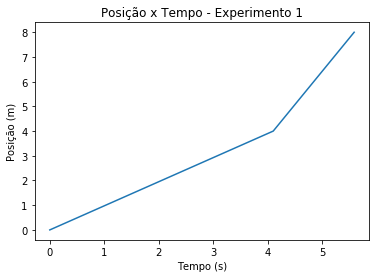

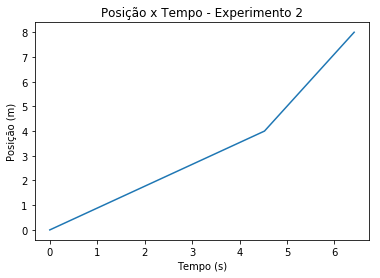

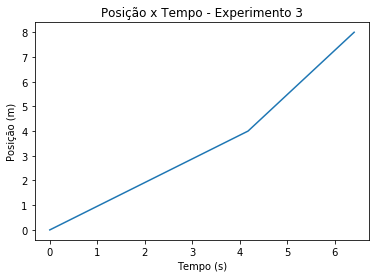

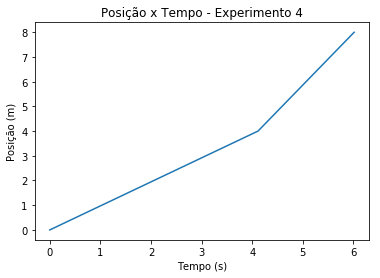

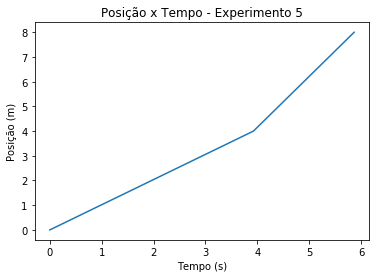

In [3]:
txe = [] #tempos para cruzar 4m e 8m para cada experimento
vxe = [] #velocidades médias nos intervalos [0,4] e [4,8] para cada experimento
tme = 0.0 #tempo médio exmperimental (para descer a rampa de 8m)
vme = 0.0 #velocidade média experimental

#Lê e organiza os dados
data = pd.read_csv('skate_tempos.csv', sep=';', decimal='.')    
data = data.as_matrix().transpose()

counter = 1
i = 1
vme = 0.0
tme = 0.0

#Plota gráfico de posição x tempo para cada experimento
while i < 11:
    pyplot.figure()
    pyplot.xlabel("Tempo (s)")
    pyplot.ylabel("Posição (m)")
    pyplot.title("Posição x Tempo - Experimento {}".format(counter))
    t4 = (data[i][0] + data[i+1][0])/2
    t8 = (data[i][1] + data[i+1][1])/2
    v4 = 4/t4
    v8 = 4/(t8-t4)
    txe.append([0,t4,t8])
    vxe.append([0,v4,v8])
    vme += 8/t8
    tme += t8
    pyplot.plot([0,t4,t8],[0,4,8])
    pyplot.show()
    counter+=1
    i+=2

#Médias    
vme = vme/5
tme = tme/5


## Dados simulados

O quarto bloco de código simula os experimentos utilizando os algoritmos de Euler e Euler-Cromer, com e sem atrito, e calcula a diferença entre a posição final nos dois algoritmos.

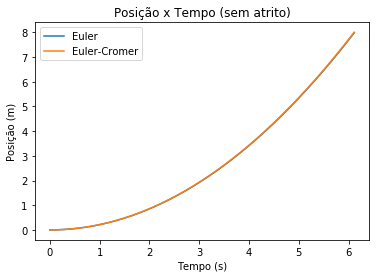

Diferença entre os algoritmos: 0.026m


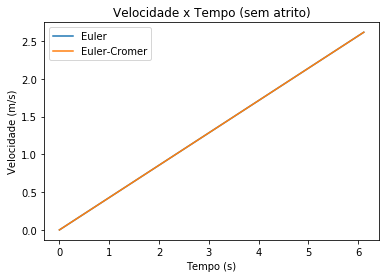

Diferença entre os algoritmos: 0.000m/s


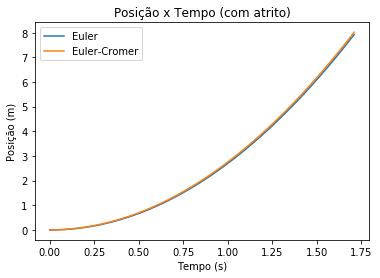

Diferença entre os algoritmos: 0.094m


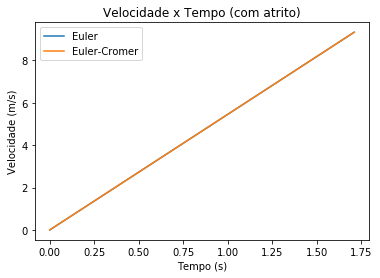

Diferença entre os algoritmos: 0.000m/s


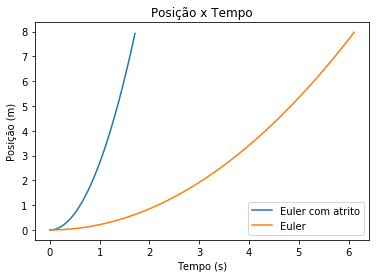

Diferença entre com/sem atrito: 7.974m


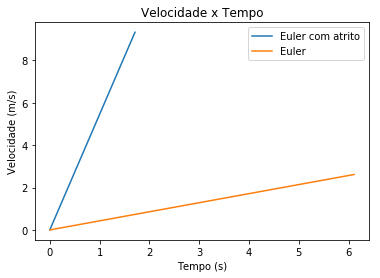

Diferença entre com/sem atrito: 2.615m/s


In [4]:
xs = [] #posição simulada por Euler
vs = [] #velocidade simulada por Euler
xsc = [] #posição simulada por Euler-Cromer
vsc = [] #velocidade simulada por Euler-Cromer
tempo = []
tms = 0.0 #tempo médio simulado
vms = 0.0 #velocidade média simulada    

#Simula os experimentos utilizando algoritmo de Euler sem atrito
x = 0.0 #onde 0 é o inicio da rampa e 8 o final
v = 0.0 #sai do repouso
a = g*(math.sin(theta)) #rampa
t = 0.0 #tempo inicial

S = initState(x,v,a,t)
Sc = initState(x,v,a,t)

#Faz a simulação até atingir 8m
while S[0] < 8:
    xs.append(S[0])
    vs.append(S[1])
    xsc.append(Sc[0])
    vsc.append(Sc[1])
    tempo.append(S[3])
    nextState(S, dt)
    nextStateCromer(Sc, dt)

#Médias
tms = S[3] #tempo médio simulado
vms = S[0]/tms #velocidade média simulado

#Plota o resultado das simulações

pyplot.figure()
pyplot.plot(tempo, xs, label='Euler')
pyplot.plot(tempo, xsc, label='Euler-Cromer')
pyplot.title("Posição x Tempo (sem atrito)")
pyplot.xlabel("Tempo (s)")
pyplot.ylabel("Posição (m)")
pyplot.legend()
pyplot.show()

print("Diferença entre os algoritmos: %.3fm" %(abs(Sc[0]-S[0])))

pyplot.figure()
pyplot.plot(tempo, vs, label='Euler')
pyplot.plot(tempo, vsc, label='Euler-Cromer')
pyplot.title("Velocidade x Tempo (sem atrito)")
pyplot.xlabel("Tempo (s)")
pyplot.ylabel("Velocidade (m/s)")
pyplot.legend()
pyplot.show()

print("Diferença entre os algoritmos: %.3fm/s" %(abs(Sc[1]-S[1])))

#Simula os experimentos utilizando algoritmo de Euler com atrito
x = 0.0 #onde 0 é o inicio da rampa e 8 o final
v = 0.0 #sai do repouso
a = -g*(math.sin(theta)-atrito*math.cos(theta)) #rampa
t = 0.0 #tempo inicial

S = initState(x,v,a,t)
Sc = initState(x,v,a,t)

xsa = []
vsa = []
xsca = []
vsca = []
tempoa = []

#Faz a simulação até atingir 8m
while S[0] < 8:
    xsa.append(S[0])
    vsa.append(S[1])
    xsca.append(Sc[0])
    vsca.append(Sc[1])
    tempoa.append(S[3])
    nextState(S, dt)
    nextStateCromer(Sc, dt)

#Médias
tmsa = S[3] #tempo médio simulado
vmsa = S[0]/tmsa #velocidade média simulada

#Plota o resultado das simulações e compara os diferentes algoritmos e o fato de usarmos ou não o atrito

pyplot.figure()
pyplot.plot(tempoa, xsa, label='Euler')
pyplot.plot(tempoa, xsca, label='Euler-Cromer')
pyplot.title("Posição x Tempo (com atrito)")
pyplot.xlabel("Tempo (s)")
pyplot.ylabel("Posição (m)")
pyplot.legend()
pyplot.show()

print("Diferença entre os algoritmos: %.3fm" %(abs(Sc[0]-S[0])))

pyplot.figure()
pyplot.plot(tempoa, vsa, label='Euler')
pyplot.plot(tempoa, vsca, label='Euler-Cromer')
pyplot.title("Velocidade x Tempo (com atrito)")
pyplot.xlabel("Tempo (s)")
pyplot.ylabel("Velocidade (m/s)")
pyplot.legend()
pyplot.show()

print("Diferença entre os algoritmos: %.3fm/s" %(abs(Sc[1]-S[1])))

pyplot.figure()
pyplot.plot(tempoa, xsa, label='Euler com atrito')
pyplot.plot(tempo, xs, label='Euler')
pyplot.title("Posição x Tempo")
pyplot.xlabel("Tempo (s)")
pyplot.ylabel("Posição (m)")
pyplot.legend()
pyplot.show()

print("Diferença entre com/sem atrito: %.3fm" %(abs(xs[-1]-xsa[0])))

pyplot.figure()
pyplot.plot(tempoa, vsa, label='Euler com atrito')
pyplot.plot(tempo, vs, label='Euler')
pyplot.title("Velocidade x Tempo")
pyplot.xlabel("Tempo (s)")
pyplot.ylabel("Velocidade (m/s)")
pyplot.legend()
pyplot.show()

print("Diferença entre com/sem atrito: %.3fm/s" %(abs(vs[-1]-vsa[0])))
    

## Comparações

O quinto bloco de código compara os dados experimentais e simulados através da sobreposição dos gráficos e calculando a diferença entre os tempos médios experimentais e simulados, assim como entre as velocidades.

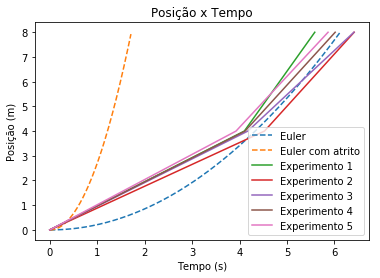

Tempo médio para percorrer 8m experimental: 6.058s
Tempo médio simulado: 6.120s
Erro médio sem atrito: 0.062s
Erro médio com atrito: 4.338s


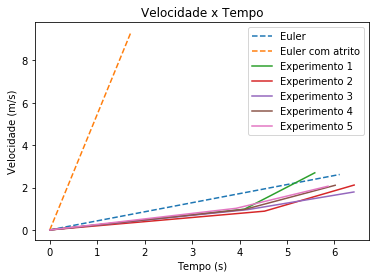

Velocidade média experimental: 1.324m/s
Velocidade média simulada: 1.307m/s
Erro médio sem atrito: 0.017m/s
Erro médio com atrito: 3.338m/s


In [5]:
#Compara os dados experimentais e simulados
pyplot.figure()
pyplot.plot(tempo, xs,linestyle='--',label='Euler')
pyplot.plot(tempoa, xsa,linestyle='--',label='Euler com atrito')
for i in range(5):
    pyplot.plot(txe[i],[0,4,8],label='Experimento {}'.format(i+1))
pyplot.title("Posição x Tempo")
pyplot.xlabel("Tempo (s)")
pyplot.ylabel("Posição (m)")
pyplot.legend()
pyplot.show()

print("Tempo médio para percorrer 8m experimental: %.3fs" %(tme))
print("Tempo médio simulado: %.3fs" %(tms))
print("Erro médio sem atrito: %.3fs" %(abs(tme-tms)))
print("Erro médio com atrito: %.3fs" %(abs(tme-tmsa)))

pyplot.figure()
pyplot.plot(tempo, vs,linestyle='--',label='Euler')
pyplot.plot(tempoa, vsa,linestyle='--',label='Euler com atrito')
for i in range(5):
    pyplot.plot(txe[i],vxe[i],label='Experimento {}'.format(i+1))
pyplot.title("Velocidade x Tempo")
pyplot.xlabel("Tempo (s)")
pyplot.ylabel("Velocidade (m/s)")
pyplot.legend()
pyplot.show()

print("Velocidade média experimental: %.3fm/s" %(vme))
print("Velocidade média simulada: %.3fm/s" %(vms))
print("Erro médio sem atrito: %.3fm/s" %(abs(vms-vme)))
print("Erro médio com atrito: %.3fm/s" %(abs(vmsa-vme)))
    

## Dados do Acelerômetro

O sexto bloco de código plota os gráficos do acelerômetro sobrepostos pelos gráficos de cada experimento.

skate1


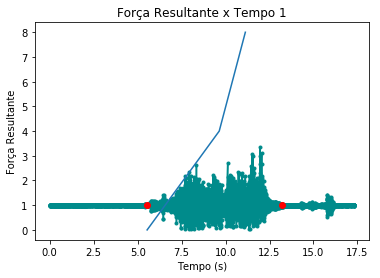

skate2


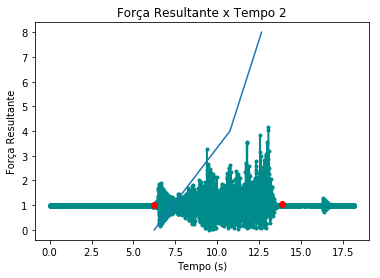

skate3


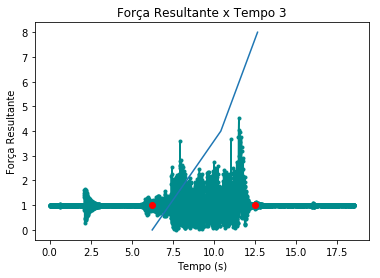

skate4


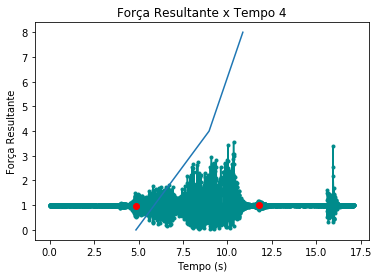

skate5


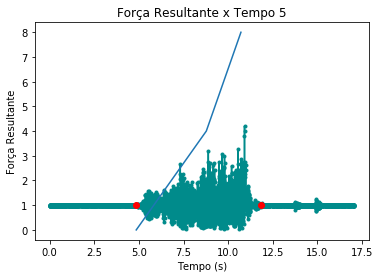

In [6]:
#Plota gráfico de posição x tempo para cada experimento
for i in range(5):
    pyplot.figure()
    pyplot.xlabel("Tempo (s)")
    pyplot.ylabel("Força Resultante")
    pyplot.title("Força Resultante x Tempo {}".format(i+1))
    filename='skate{}'.format(i+1)
    print(filename)
    begin = acelerometro(filename,5.0,15)
    pyplot.plot([begin+txe[i][0],begin+txe[i][1],begin+txe[i][2]],[0,4,8])
    pyplot.show()

## Animação

O sétimo bloco de código faz a animação dos dados simulados.

In [7]:
x = xs
y = 8*math.sin(theta)
width = math.sqrt(8**2 - y**2)

pyplot.rcParams["figure.figsize"] = [5,5]
fig = pyplot.figure()
ax = fig.add_subplot(111, autoscale_on=False, xlim=(0, 9), ylim=(0, 3))
ax.grid()

line1, = ax.plot([], [], 'o-', lw=2)
line2, = ax.plot([], [], 'o-', lw=2)
line3, = ax.plot([], [], 'o-', lw=2)
point, = ax.plot([], 'o')
time_template = 'time = %.1fs'
time_text = ax.text(0.1, 0.9, '', transform=ax.transAxes)

def init():
    line1.set_data([0,0], [y,0])
    line2.set_data([width], [0,0])
    line3.set_data([width], [y,0])
    point.set_data([0,y])
    time_text.set_text('')
    return line1, line2, line3, time_text

def animate(i):
    point.set_data([x[i],y+0.05 - x[i]*math.sin(theta)])
    line1.set_data([0,0], [0,y])
    line2.set_data([0,width], [0,0])
    line3.set_data([0,width], [y,0])
    time_text.set_text(time_template % (i*dt))
    return point, line1, line2, line3, time_text

anim = animation.FuncAnimation(fig, animate, np.arange(1, len(x)),
                              interval=5, blit=True, init_func=init)
pyplot.close()

In [8]:
HTML(anim.to_html5_video())

## Análise

Inicialmente, parece existir uma grande variação no gráfico de Velocidade x Tempo, porém ao se analisar as velocidades medias notamos que o erro, na verdade, é bem pequeno. Isso se deve pela escala do gráfico. O peculiar formato das retas é devido à quantidade insuficiente de marcações durante o percurso, o que causa um crescimento repentino entre marcações. 

Por outro lado, o gráfico de Posição x Tempo parece se aproximar do simulado, mas novamente é uma ilusão gerada pela escala do gráfico. Quando analisamos a velocidade média dos experimentos e da simulação, vemos que o erro é bem grande. Isso se deve, principalmente, ao fato da simulação considerar uma rampa perfeita, enquanto a rampa usada para os experimentos possuía leves erros de inclinação durante seu percurso. Além disso, houve somente duas marcações de tempo, o que prejudicou uma captura fiel da variação da posição do skate. 

Outros fatores não considerados durante a simulação que agravaram o erro foram a falta do cálculo preciso do atrito entre o material da roda do skate e do concreto ( incluindo o fato de não diferenciarmos o atrito estático do dinâmico ) e a desconsideração da resistência do ar.

# Lançamento Horizontal

O oitavo bloco de código define algumas funções que serão utilizadas nas seções do código referentes ao experimento do lançamento horizontal.

São elas: <span style="color:blue">initState</span>(), que inicializa o vetor de estados, <span style="color:blue">nextState</span>(), que calcula o próximo estado utilizando o algoritmo de Euler, <span style="color:blue">nextStateCromer</span>(), que calcula o próximo estado utilizando o algoritmo de Euler-Cromer, e define algumas constantes como o ângulo da rampa *theta* e o coeficiente de atrito do concreto *atrito*.

Também inicializa algumas listas e variáveis que serão calculadas nos blocos a seguir.

In [9]:
#Inicializa o vetor de estados
#S = [posição(x), posição(y), velocidade(x), velocidade(y), aceleração(x), aceleração(y), tempo]
def initState(x,y,vx,vy,ax,ay,t):
    S = [x,y,vx,vy,ax,ay,t]
    return(S)

#Calcula o próximo estado pelo algoritmo de Euler
# x = x + vx*dt
# y = y + vx*dt
# vx = vx + ax*dt
# vy = vy + ay*dt
# ax = arrumar
# ay é constante (g)
# t = t + dt
def nextState(S,m,dt):
    S[0] = S[0] + S[2]*dt
    S[1] = S[1] + S[3]*dt
    S[2] = S[2] + S[4]*dt
    S[3] = S[3] + S[5]*dt
    S[4] = ((0.0129 * 0.295 * 6.66)/2 * S[2]**2)/m
    S[6] = S[6] + dt
    return(S)

#Calcula o próximo estado pelo algoritmo de Euler
# ax = -0.0001*vx (simular resistência do ar)
# vx = vx + ax*dt
# vy = vy + ay*dt
# x = x + vx*dt
# y = y + vx*dt
# ay é constante (g)
# t = t + dt
def nextStateCromer(S,m,dt):
    S[4] = ((0.0129 * 0.295 * 6.66)/2 * S[2]**2)/m
    S[2] = S[2] + S[4]*dt
    S[3] = S[3] + S[5]*dt
    S[0] = S[0] + S[2]*dt
    S[1] = S[1] + S[3]*dt
    S[6] = S[6] + dt
    return(S)

xme = 0.0 #posição média experimental
tme = 0.0 #tempo médio experimental
posxe = [] #coordenada x do projétil (Experimental) 
posye = [] #coordenada y do projétil (Experimental) 
posx = [] #coordenada x do projétil (Euler)
posy = [] #coordenada y do projétil (Euler)
velx = [] #velocidade na direção do eixo x (Euler)
vely = [] #velocidade na direção do eixo y (Euler)
posxc = [] #coordenada x do projétil (Euler-Cromer)
posyc = [] #coordenada y do projétil (Euler-Cromer)
velxc = [] #velocidade na direção do eixo x (Euler-Cromer)
velyc = [] #velocidade na direção do eixo y (Euler-Cromer)
tempo = [] #tempo para Euler
tempoc = [] #tempo para Euler-Cromer
time = []
m = 1.44 #massa da bala

## Dados experimentais

O nono bloco de código lê os dados da planilha csv, plota os gráficos experimentais e calcula a velocidade e o tempo médio dos 5 experimentos.

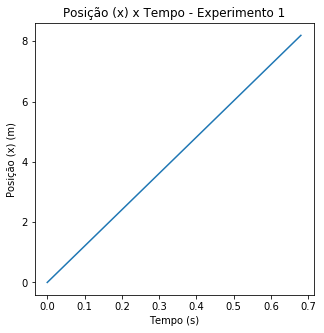

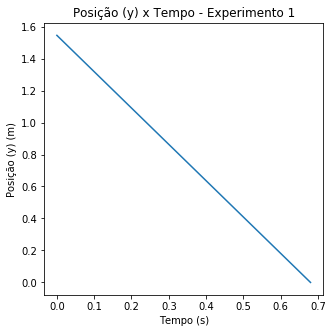

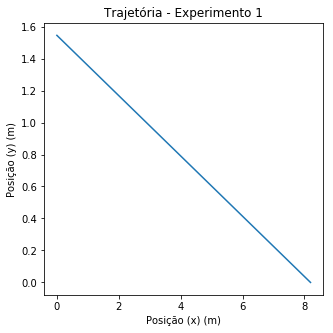

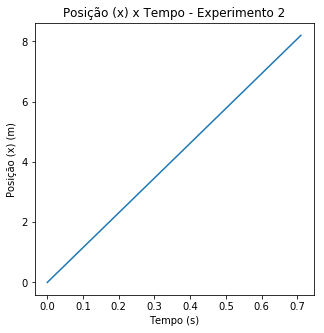

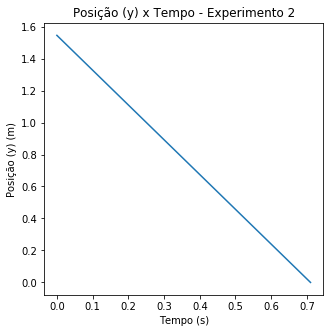

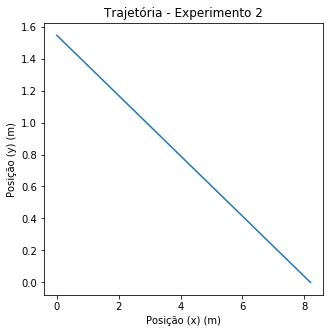

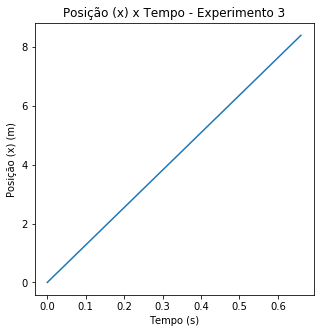

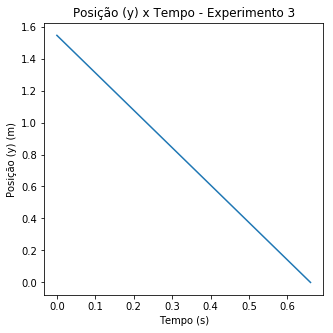

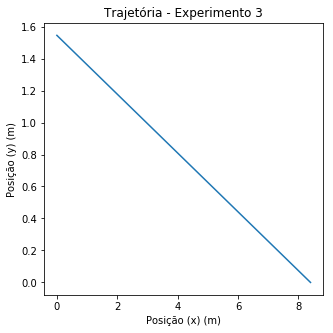

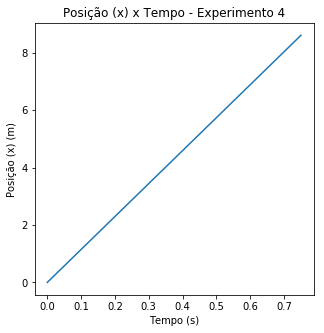

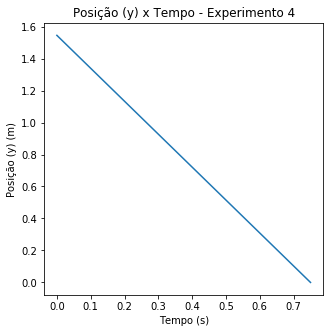

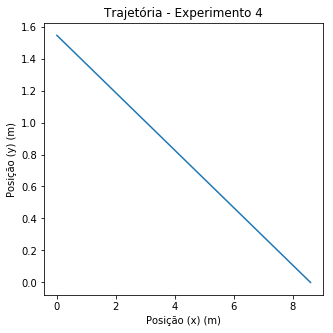

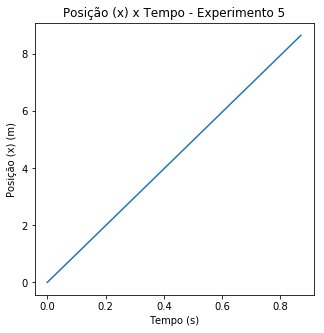

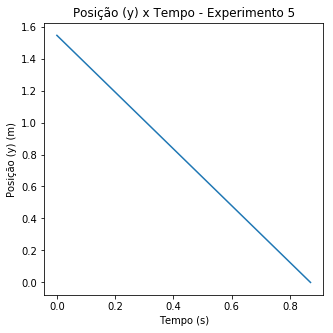

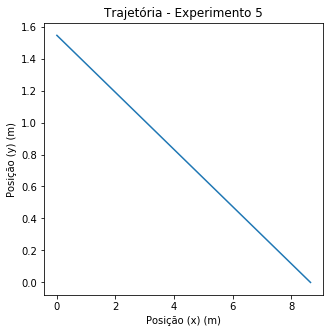

In [10]:
#Lê e organiza os dados
data = pd.read_csv('lancamento_tempos.csv', sep='\t', decimal=',')    
data = data.as_matrix().transpose()

xme = 0.0
tme = 0.0

#Plota gráfico de posição (x) x tempo para cada experimento
for i in range(5):
    pyplot.figure()
    pyplot.xlabel("Tempo (s)")
    pyplot.ylabel("Posição (x) (m)")
    pyplot.title("Posição (x) x Tempo - Experimento {}".format(i+1))
    y = 1.545
    x = data[i][0]
    t = data[i][1]
    xme += x
    tme += t
    pyplot.plot([0,t],[0,x])
    time.append([0,t])
    posxe.append([0,x])
    posye.append([1.545,0])
    pyplot.show()
    pyplot.figure()
    pyplot.xlabel("Tempo (s)")
    pyplot.ylabel("Posição (y) (m)")
    pyplot.title("Posição (y) x Tempo - Experimento {}".format(i+1))
    pyplot.plot([0,t],[1.545,0])
    pyplot.show()
    pyplot.figure()
    pyplot.xlabel("Posição (x) (m)")
    pyplot.ylabel("Posição (y) (m)")
    pyplot.title("Trajetória - Experimento {}".format(i+1))
    pyplot.plot([0,x],[1.545,0])
    pyplot.show()

tme = tme/5
xme = xme/5

## Dados simulados

O décimo bloco de código simula os experimentos utilizando os algoritmos de Euler e Euler-Cromer e calcula a diferença entre a posição final nos dois algoritmos.

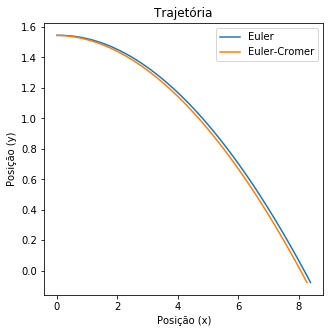

Diferença entre os algoritmos: 0.118m


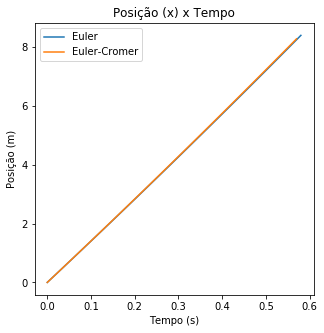

Diferença entre os algoritmos: 0.118m


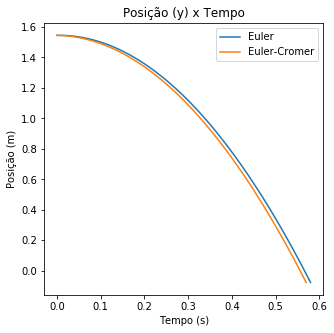

Diferença entre os algoritmos: 0.010s


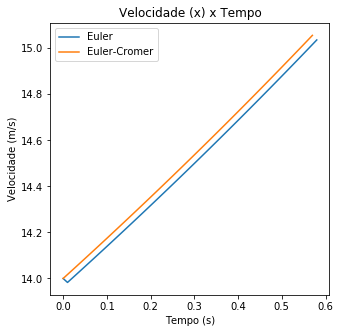

Diferença entre os algoritmos: 0.020m/s


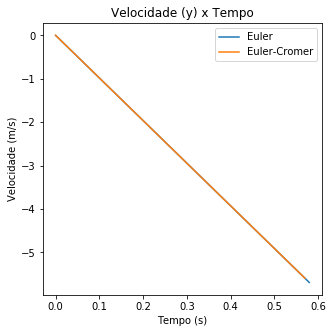

Diferença entre os algoritmos: 0.098m/s


In [11]:
#Simula os experimentos utilizando algoritmo de Euler para sistemas dinâmicos
x = 0 #posição(x) inicial do projétil
y = 1.545 #altura inicial do projétil
vx = 14 #estimativa de velocidade inicial (x) do projétil
vy = 0.0 #inicialmente, nenhuma força vertical age sobre o projétil
ax = -((0.0129 * 0.295 * 6.66)/2 * vx**2)/m #resistência do ar
ay = -g #aceleração causada pela força peso
t = 0.0 #tempo inicial

S = initState(x,y,vx,vy,ax,ay,t)
Sc = initState(x,y,vx,vy,ax,ay,t)

#Faz a simulação até atingir o chão (0m)
while S[1] > -0.1 or Sc[1] > -0.1:
    if (S[1] > -0.1):
        posx.append(S[0])
        posy.append(S[1])
        velx.append(S[2])
        vely.append(S[3])
        tempo.append(S[6])
        nextState(S, m, dt)

    if (Sc[1] > -0.1):
        posxc.append(Sc[0])
        posyc.append(Sc[1])
        velxc.append(Sc[2])
        velyc.append(Sc[3])
        tempoc.append(Sc[6])
        nextStateCromer(Sc, m, dt)

pyplot.figure()
pyplot.plot(posx, posy, label='Euler')
pyplot.plot(posxc, posyc, label='Euler-Cromer')
pyplot.title("Trajetória")
pyplot.xlabel("Posição (x)")
pyplot.ylabel("Posição (y)")
pyplot.legend()
pyplot.show()

print("Diferença entre os algoritmos: %.3fm" %(abs(Sc[0]-S[0])))

pyplot.figure()
pyplot.plot(tempo[:len(posx)], posx, label='Euler')
pyplot.plot(tempo[:len(posxc)], posxc, label='Euler-Cromer')
pyplot.title("Posição (x) x Tempo")
pyplot.xlabel("Tempo (s)")
pyplot.ylabel("Posição (m)")
pyplot.legend()
pyplot.show()

print("Diferença entre os algoritmos: %.3fm" %(abs(Sc[0]-S[0])))

pyplot.figure()
pyplot.plot(tempo[:len(posy)], posy, label='Euler')
pyplot.plot(tempo[:len(posyc)], posyc, label='Euler-Cromer')
pyplot.title("Posição (y) x Tempo")
pyplot.xlabel("Tempo (s)")
pyplot.ylabel("Posição (m)")
pyplot.legend()
pyplot.show()

print("Diferença entre os algoritmos: %.3fs" %(abs(tempo[len(posy)-1]-tempo[len(posyc)-1])))

pyplot.figure()
pyplot.plot(tempo[:len(velx)], velx, label='Euler')
pyplot.plot(tempo[:len(velxc)], velxc, label='Euler-Cromer')
pyplot.title("Velocidade (x) x Tempo")
pyplot.xlabel("Tempo (s)")
pyplot.ylabel("Velocidade (m/s)")
pyplot.legend()
pyplot.show()

print("Diferença entre os algoritmos: %.3fm/s" %(abs(Sc[2]-S[2])))

pyplot.figure()
pyplot.plot(tempo[:len(vely)], vely, label='Euler')
pyplot.plot(tempo[:len(velyc)], velyc, label='Euler-Cromer')
pyplot.title("Velocidade (y) x Tempo")
pyplot.xlabel("Tempo (s)")
pyplot.ylabel("Velocidade (m/s)")
pyplot.legend()
pyplot.show()

print("Diferença entre os algoritmos: %.3fm/s" %(abs(Sc[3]-S[3])))
        

## Comparações

O décimo primeiro bloco de código compara os dados experimentais e simulados através da sobreposição dos gráficos e calculando a diferença entre os tempos médios experimentais e simulados, assim como entre as velocidades.

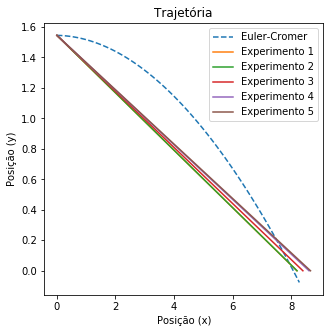

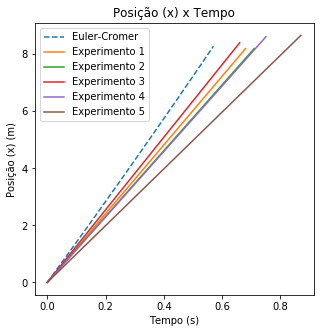

Distância (x) experimental percorrida pela bala: 8.413m
Distância (x) simulada: 8.398m
Erro médio: 0.015m


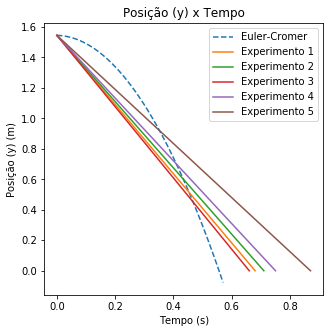

Tempo médio experimental para bala atingir o chão: 0.734s
Tempo simulado: 0.570s
Erro médio: 0.164s


In [12]:
pyplot.figure()
pyplot.plot(posxc, posyc,linestyle='--',label='Euler-Cromer')
for i in range(5):
    pyplot.plot(posxe[i],posye[i],label='Experimento {}'.format(i+1))
pyplot.title("Trajetória")
pyplot.xlabel("Posição (x)")
pyplot.ylabel("Posição (y)")
pyplot.legend()
pyplot.show()

pyplot.figure()
pyplot.plot(tempoc[:len(posxc)], posxc,linestyle='--',label='Euler-Cromer')
for i in range(5):
    pyplot.plot(time[i],posxe[i],label='Experimento {}'.format(i+1))
pyplot.title("Posição (x) x Tempo")
pyplot.xlabel("Tempo (s)")
pyplot.ylabel("Posição (x) (m)")
pyplot.legend()
pyplot.show()

print("Distância (x) experimental percorrida pela bala: %.3fm" %(xme))
print("Distância (x) simulada: %.3fm" %(posx[-1]))
print("Erro médio: %.3fm" %(abs(posx[-1]-xme)))

pyplot.figure()
pyplot.plot(tempoc[:len(posyc)], posyc,linestyle='--',label='Euler-Cromer')
for i in range(5):
    pyplot.plot(time[i],posye[i],label='Experimento {}'.format(i+1))
pyplot.title("Posição (y) x Tempo")
pyplot.xlabel("Tempo (s)")
pyplot.ylabel("Posição (y) (m)")
pyplot.legend()
pyplot.show()

print("Tempo médio experimental para bala atingir o chão: %.3fs" %(tme))
print("Tempo simulado: %.3fs" %(tempoc[-1]))
print("Erro médio: %.3fs" %(abs(tme-tempoc[-1])))
    

## Animação

O décimo segundo bloco de código faz a animação dos dados simulados.

In [13]:
x = posxc
y = posyc
dt = 0.01

pyplot.rcParams["figure.figsize"] = [5,5]
fig = pyplot.figure()
ax = fig.add_subplot(111, autoscale_on=False, xlim=(0, 9), ylim=(0, 3))
ax.grid()

point, = ax.plot([], 'o',color='green')
line, =ax.plot([],[], 'o', color='lightgray')
time_template = 'time = %.1fs'
time_text = ax.text(0.1, 0.9, '', transform=ax.transAxes)

def init():
    point.set_data([0,0.44])
    time_text.set_text('')
    return point, time_text

def animate(i):
    line.set_data(x[:i],y[:i])
    point.set_data([x[i],y[i]])
    time_text.set_text(time_template % (i*dt))
    return point, line, time_text

anim = animation.FuncAnimation(fig, animate, np.arange(1, len(y)),
                              interval=20, blit=True, init_func=init)
pyplot.close()

In [14]:
HTML(anim.to_html5_video())

## Análise

Podemos ver que as trajetórias e a evolução da posição no decorrer do tempo de todos os 5 experimentos estão muito semelhantes. A diferença de tempo e de espaço percorrido pelos projéteis é mínima. 

Porém, ao comparar com os dados teóricos gerados pelos métodos de Euler e Euler-Cromer, vemos que a trajetória esperada é muito diferente das que conseguimos medir experimentalmente (espera-se uma parábola, porém obtemos retas). Da mesma forma, os gráficos de posição em y pelo tempo diferem da teoria. Isso ocorre, principalmente, porque temos poucas medições de tempo/posição (apenas dois pontos: inicial e final). Não foi possível realizar medidas mais precisas pois é muito difícil determinar a posição nos eixos quando o projétil está em suspensão, além de ser inviável ter muitas marcações em um período muito curto de tempo (uma vez que o trajeto leva menos de 1 segundo). 

Por outro lado, comparando com o gráfico de tempo por posição em x, vemos que os resultados estão razoáveis. As pequenas dissemelhanças entre o esperado e o realizado devem-se a diversos fatores práticos, tais como a resistência do ar real que pode divergir dos cálculos, ou até mesmo a inconsistência da pistola NERF.

# Pêndulo

O décimo terceiro bloco de código define algumas funções que serão utilizadas nas seções do código referentes ao experimento do pêndulo.
São elas: <span style="color:blue">initState</span>(), que inicializa o vetor de estados, <span style="color:blue">nextState</span>(), que calcula o próximo estado utilizando o algoritmo de Euler, <span style="color:blue">nextStateCromer</span>(), que calcula o próximo estado utilizando o algoritmo de Euler-Cromer, e define algumas constantes como o ângulo da rampa *theta* e o coeficiente de atrito do concreto *atrito*.

Também inicializa algumas listas e variáveis que serão calculadas nos blocos a seguir.

In [15]:
#Inicializa o vetor de estados
#S = [theta, dtheta, tempo]
def initState(theta,dtheta,t):
    S = [theta,dtheta,t]
    return(S)

#Calcula o próximo estado pelo algoritmo de Euler
#theta = theta + dtheta*dt
#dtheta = dtheta - (g/l)*seno(theta)*dt
#t = t + dt
def nextState(S,g,l,dt):
    S[0] = S[0] + S[1]*dt
    S[1] = S[1] - (g/l)*math.sin(S[0])*dt
    S[2] = S[2] + dt
    return(S)

#Calcula o próximo estado pelo algoritmo de Euler
#theta = theta + dtheta*dt
#dtheta = dtheta - (g/l)*seno(theta)*dt
#t = t + dt
def nextStateCromer(S,g,l,dt):
    S[1] = S[1] - (g/l)*math.sin(S[0])*dt
    S[0] = S[0] + S[1]*dt
    S[2] = S[2] + dt
    return(S)

posx = [] #coordenada x do pêndulo
posy = [] #coordenada y do pêndulo
tempo = [] 
per = [] #períodos experimentais
thetas = [] #valores de theta
l = 0.673 #comprimento do barbante
theta = math.pi/6 #ângulo inicial
dtheta = 0
t = 0.0
media = 0.0

## Dados experimentais

O décimo quarto bloco de código lê os dados da planilha csv, plota os gráficos experimentais e calcula a velocidade e o tempo médio dos 5 experimentos.

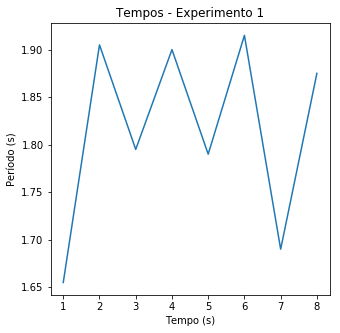

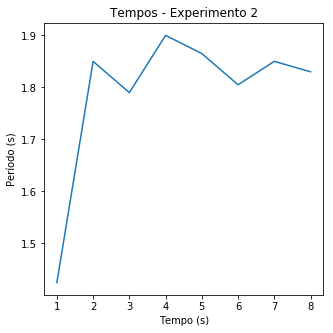

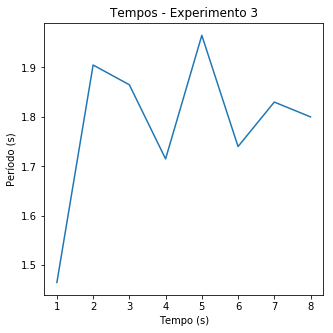

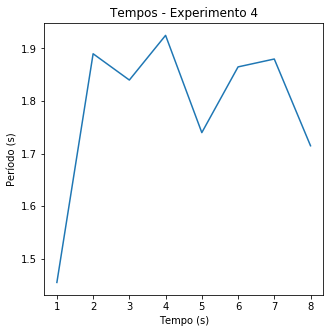

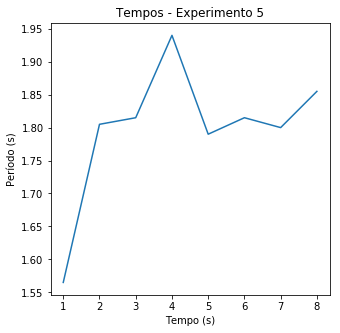

In [16]:
#Lê e organiza os dados
data = pd.read_csv('pendulo_tempos.csv', sep=';', decimal='.')        
data = data.as_matrix().transpose()

per = [[0],[0]*8,[0]*8,[0]*8,[0]*8,[0]*8]
media = 0.0
i = 1
ctr = 1

#Pega os períodos amostrados experimentalmente e calcula a média deles
while i < 10:
    pyplot.figure(0)
    pyplot.xlabel("Tempo (s)")
    pyplot.ylabel("Período (s)")
    pyplot.title("Tempos - Experimento {}".format(ctr))
    for j in range(8):
        per[ctr][j] = (data[i][j] + data[i+1][j])/2
        media += per[ctr][j]
    pyplot.plot([1,2,3,4,5,6,7,8],per[ctr])
    pyplot.show()
    i+=2
    ctr+=1

media = media/40

## Dados simulados

O décimo quinto bloco de código simula os experimentos utilizando os algoritmos de Euler e Euler-Cromer e calcula a diferença entre a posição final nos dois algoritmos.

In [17]:
S = initState(theta,dtheta,t)
posx = []
posxc = []
posy = []
posyc = []
tempo = []
tempoc = []
thetasc = []

for i in range(500):
    posx.append(math.sin(S[0])*l)
    posxc.append(math.sin(Sc[0]*l))
    posy.append(-math.cos(S[0]*l))
    posyc.append(-math.cos(Sc[0])*l)
    thetas.append(S[0])
    thetasc.append(Sc[0])
    tempo.append(S[2])
    tempoc.append(Sc[2])
    nextState(S,g,l, dt)

pyplot.figure(0)
pyplot.plot(posx, posy, label='Euler')
pyplot.plot(posxc, posyc, label='Euler-Cromer')
pyplot.title("Trajetória: Euler x Euler-Cromer")
pyplot.xlabel("x")
pyplot.ylabel("y")
pyplot.show()

pyplot.figure(0)
pyplot.plot(tempo, posx, label='Euler')
pyplot.plot(tempoc, posxc, label='Euler-Cromer')
pyplot.title("Posição (x) x Tempo")
pyplot.xlabel("Tempo (s)")
pyplot.ylabel("x (m)")
pyplot.show()

print("Diferença entre os algoritmos: %.3fs" %(abs(math.sin(S[0])-math.sin(Sc[0])))

pyplot.figure(0)
pyplot.plot(tempo, posy, label='Euler')
pyplot.plot(tempoc, posyc, label='Euler-Cromer')
pyplot.title("Posição (y) x Tempo")
pyplot.xlabel("Tempo (s)")
pyplot.ylabel("y (m)")
pyplot.show()
      
print("Diferença entre os algoritmos: %.3fs" %(abs(math.cos(S[0])-math.cos(Sc[0])))

pyplot.figure(0)
pyplot.plot(tempo, thetas)
pyplot.title("Angulo x Tempo")
pyplot.xlabel("Tempo (s)")
pyplot.ylabel("Angulo (rad)")
pyplot.show()

print("Diferença entre os algoritmos: %.3fs" %(abs(S[0]-Sc[0]))


SyntaxError: invalid syntax (<ipython-input-17-209f5f5c8a0b>, line 39)

## Comparações

O décimo sexto bloco de código compara os dados experimentais e simulados através da sobreposição dos gráficos e calculando a diferença entre os tempos médios experimentais e simulados, assim como entre as velocidades.

In [ ]:
#Compara os períodos amostrados com obtido pela simulação
T = 2*math.pi*math.sqrt(l/g)
print("Período esperado: %.3fs" %(T))
print("Período obtido (média dos experimentos): %.3fs" %(media))
print("Erro: %.3fs" %(abs(T-media)))

pyplot.figure(0)
pyplot.plot([1,2,3,4,5,6,7],[T]*7,linestyle='--',label='Teórico')
for i in range(1,6):
    pyplot.plot([1,2,3,4,5,6,7,8],per[i],label='Experimento {}'.format(i))
pyplot.title("Períodos")
pyplot.xlabel("Voltas")
pyplot.ylabel("Tempo (s)")
pyplot.legend()
pyplot.show()    

## Dados do Acelerômetro

O décimo sétimo bloco de código plota os gráficos do acelerômetro sobrepostos pelos gráficos de cada experimento.

In [ ]:
data = pd.read_csv('pendulo_tempos.csv', sep=';', decimal='.')        
data = data.as_matrix().transpose()

media = 0.0
per = [[0],[0]*8,[0]*8,[0]*8,[0]*8,[0]*8]
i = 1
ctr = 1
while i < 10:
    pyplot.figure(0)
    pyplot.xlabel("Tempo (s)")
    pyplot.ylabel("Período (s)")
    pyplot.title("Tempos - Experimento {}".format(ctr))
    for j in range(8):
        per[ctr][j] = (data[i][j] + data[i+1][j])/2
        media += per[ctr][j]
    filename='pendulo{}'.format(ctr)
    print(filename)
    begin = acelerometro(filename,17.0,55)
    pyplot.plot([begin+per[ctr][0],begin+sum(per[ctr][0:2]),begin+sum(per[ctr][0:3]),begin+sum(per[ctr][0:4]),
                 begin+ sum(per[ctr][0:5]),begin+sum(per[ctr][0:6]),begin+sum(per[ctr][0:7]),begin+sum(per[ctr][0:8])]
                ,per[ctr],'-o',color='red')
    pyplot.axis([begin,begin+sum(per[ctr][0:8])+1,-2,10])
    pyplot.show()
    i+=2
    ctr+=1

print("Gráficos completos do acelerômetro para o pêndulo")
print("")
for i in range(1,6):
    filename='pendulo{}'.format(i)
    print(filename)
    acelerometro(filename,17.0,55,20,True)
        

## Animação

O último bloco de código faz a animação dos dados simulados.

In [ ]:
x = []
y = []

for o in thetas:
    x.append(math.sin(o)*l)
    y.append(-math.cos(o)*l)

pyplot.rcParams["figure.figsize"] = [5,5]
fig = pyplot.figure()
ax = fig.add_subplot(111, autoscale_on=False, xlim=(-1, 1), ylim=(-1, 1))
ax.grid()

line, = ax.plot([], [], 'o-', lw=2)
time_template = 'time = %.1fs'
time_text = ax.text(0.1, 0.9, '', transform=ax.transAxes)

def init():
    line.set_data([], [])
    time_text.set_text('')
    return line, time_text

def animate(i):
    thisx = [0, x[i]]
    thisy = [0, y[i]]

    line.set_data(thisx, thisy)
    time_text.set_text(time_template % (i*dt))
    return line, time_text

anim = animation.FuncAnimation(fig, animate, np.arange(1, len(y)),
                              interval=5, blit=True, init_func=init)
pyplot.close()

In [ ]:
HTML(anim.to_html5_video())

## Análise 

Com os tempos que coletamos conseguimos apenas estimar o período do pêndulo. Apesar dos gráficos estarem relativamente inconsistentes entre um experimento e outro (devido a erro humano ao cronometrar), a média geral se manteve muito próxima da teórica.

Ao analisar os gráficos do acelerômetro podemos notar claramente os períodos reais do pêndulo. Comparando com os tempos marcados (pontos em vermelho), vemos que há um pequeno atraso de medição, o que propagou erros nos cálculos. Porém, ainda assim, pode-se considerar que os dados coletados foram precisos. 

Dos gráficos gerais do acelerômetro podemos observar os momentos de início e encerramento de cada experimento, e verifica-se que os tempos cronometrados são próximos. Além disso existem alguns pontos com valores muito abruptos durante o movimento pendular, e estes provavelmente se dão por eventuais colisões da massa com a parede.

## Considerações Finais

De acordo com os resultados obtidos e as comparações entre os dados experimentais e teóricos, os erros obtidos foram relativamente altos. No caso da rampa e do lançamento vertical, isso se deve a fatores como poucas marcações e a velocidade com que o experimento ocorre, que dificulta a medição no momento exato. O que já não ocorreu no caso do pêndulo, já que foram realizadas oito medições por experimento e o intervalo plausível para medição do período é maior. Portanto, o grupo concluiu que o pêndulo foi o experimento mais bem sucedido. 

Para futuros experimentos, devemos considerar realizar mais marcações a fim de obtermos uma amostra maior de dados para comparação com os resultados teóricos. 

Podemos notar que, para o experimento do pêndulo, os dados do acelerômetro também servem como indicador da precisão das medições realizadas pelos alunos. 

Por fim, o grupo observou que o projeto demanda dos alunos não só qualidades típicas da área de exatas como também a criatividade e a capacidade de trabalhar em grupo. Notamos também que a modelagem desses experimentos requer parâmetros adicionais concisos e específicos para se adequar aos dados experimentais

## Log

O tempo que utilizamos para concluir esse exercício programa foi aproximadamente 29 horas, sendo:
<ul>
    <li>5h para a realização dos experimentos</li>
    <li>8h para a escrita do código</li>
    <li>4h para a escrita do relatório</li>
    <li>4h para a edição do vídeo</li>
</ul>

## Vídeo do experimento

https://www.youtube.com/watch?v=X82ofFaULzg

## Contribuições dos autores

Eduardo Nascimento foi responsável por fornecer a fita e o celular para a realização dos experimentos, atirar a NERF do lançamento horizontal, escrever as considerações finais e a função acelerômetro, além de auxiliar no processo de verificação do código. 

Gabriel Massukado foi responsável por fornecer o skate, a pistola NERF, a trena e a capinha do DS (para segurar o celular no experimento do pêndulo), assim como por marcar o tempo do pêndulo e da descida na rampa, escrever a introdução e auxiliar no processo de verificação do código.

Larissa Goto foi responsável por fornecer a trena, o transferidor, giz, a toalha (que prendeu o celular no skate) e o barbante (do pêndulo), assim como por gravar os experimentos, marcar o tempo da descida na rampa e do lançamento horizontal  (e medir a distância deste), editar o vídeo dos experimentos e escrever a análise do pêndulo e do lançamento horizontal.

Nathalia Borin não estava presente no dia da realização dos experimentos devido à dificuldade de transporte causada pela greve dos caminhoneiros, mas escreveu o código que gera os gráficos e as animações.

Matheus Lima foi responsável por medir a distância do lançamento horizontal, lançar o skate, marcar o tempo do pêndulo e escrever a análise da descida em rampa, além de auxiliar no processo de verificação do código.

Todos os autores escreveram e revisaram esse artigo. Todos os autores leram e aprovaram a versão final desse artigo.